In [94]:
from random import randint
import torch
from torch import nn
from torch.utils.data import Dataset, dataloader
from torchvision.datasets import Flowers102
from torchvision.transforms import v2
from skimage import color
from torch.nn.functional import relu
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device used : {device}")

device used : cuda


In [95]:
SIZE = 128

def choose_pixel():
    return (randint(0, SIZE-1), randint(0, SIZE-1))

def ab_percent(percent=0):
    return int(SIZE**2 * percent)

class CustomFlowersDataset(Dataset):
    def __init__(self, root, split="train", transform=None, download=False):
        self.flowers_dataset = Flowers102(root=root, split=split, download=download)
        self.transform = transform

    def __getitem__(self, index):
        image, _ = self.flowers_dataset[index]


        if self.transform is not None:
            image = self.transform(image)


        l_channel = image[0, ...].unsqueeze(0)
        a_channel = image[1, ...].unsqueeze(0)
        b_channel = image[2, ...].unsqueeze(0)

        modified_a_channel = torch.zeros_like(a_channel)
        modified_b_channel = torch.zeros_like(b_channel)

        num_pixels_to_modify = ab_percent()
        
        for i in range(num_pixels_to_modify):
            chosen_pixel = choose_pixel()
            chosen_pixel_color = image[:, chosen_pixel[0], chosen_pixel[1]].unsqueeze(1).unsqueeze(2)
            modified_a_channel[:, chosen_pixel[0], chosen_pixel[1]] = chosen_pixel_color[1, 0, 0]
            modified_b_channel[:, chosen_pixel[0], chosen_pixel[1]] = chosen_pixel_color[2, 0, 0]

        lab_image = torch.cat([l_channel, modified_a_channel, modified_b_channel], dim=0)

        return lab_image, image#[1:, ...]

    def __len__(self):
        return len(self.flowers_dataset)




In [96]:
root_dir = "./ressources"

transform = v2.Compose([
	color.rgb2lab,
	v2.ToImage(),
	v2.ToDtype(torch.float32),
	v2.Resize((SIZE,SIZE), antialias=True),
])

train_dataset = CustomFlowersDataset(root=root_dir, split="test", transform=transform, download=False)
test_dataset = CustomFlowersDataset(root=root_dir, split="train", transform=transform, download=False)

Train dataset size: 6149
Test dataset size: 1020


Images shapes :torch.Size([3, 128, 128]) (input)
Images shapes :torch.Size([3, 128, 128]) (target)


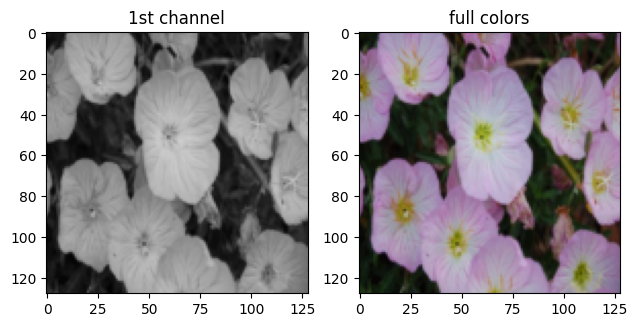

In [97]:
def tensorToImg(tensor:torch.Tensor):
	return tensor.moveaxis(0,2).detach().cpu().numpy()

print("Train dataset size:",len(train_dataset))
print("Test dataset size:",len(test_dataset))
img1, img2 = test_dataset[0]
print(f"Images shapes :{img1.shape} (input)")



fig = plt.figure()
ax1, ax2 = fig.subplots(1, 2)

ax1.imshow(color.lab2rgb(tensorToImg(img1)), cmap="grey")
ax1.set_title("1st channel")

#img_colored = torch.cat((img1[0].unsqueeze(0), img2), dim=0)
img_colored = img2
print(f"Images shapes :{img_colored.shape} (target)")

ax2.imshow(color.lab2rgb(tensorToImg(img_colored)))
ax2.set_title("full colors")
plt.tight_layout()

In [98]:
# Dataloaders
train_dataset = [train_dataset[i] for i in range(len(train_dataset))]
#train_dataset = [train_dataset[i] for i in range(10)]
train_loader = dataloader.DataLoader(train_dataset, shuffle=True, batch_size=64)
test_loader = dataloader.DataLoader(test_dataset, shuffle=True, batch_size=64)

In [99]:
# class ColorNN(nn.Module):
# 	def __init__(self, *args, **kwargs) -> None:
# 		super().__init__(*args, **kwargs)
# 		self.encoder = nn.Sequential(
# 			self.DoubleConv2d(3, 64),
# 			nn.MaxPool2d(2),
# 			self.DoubleConv2d(64, 128),
# 			nn.MaxPool2d(2),
# 			self.DoubleConv2d(128, 256),
# 			nn.MaxPool2d(2),
# 			self.DoubleConv2d(256, 512),
# 		)
# 		self.decoder = nn.Sequential(
# 			nn.ConvTranspose2d(512, 256, 2, 2),
# 			self.DoubleConv2d(256, 256),
# 			nn.ConvTranspose2d(256, 128, 2, 2),
# 			self.DoubleConv2d(128, 128),
# 			nn.ConvTranspose2d(128, 64, 2, 2),
# 			self.DoubleConv2d(64, 64),
# 		)
# 		self.final = nn.Conv2d(64, 2, 1)
	
# 	def forward(self, X):
# 		return self.final(self.decoder(self.encoder(X)))
		
	
# 	def DoubleConv2d(self, c_in, c_out, k_size=3):
# 		return nn.Sequential(
# 			nn.Conv2d(c_in, c_out, k_size, padding=1),
# 			nn.ReLU(),
# 			nn.Conv2d(c_out, c_out, k_size, padding=1),
# 			nn.ReLU()
# 		)
from src.Models import NetworkColor2

In [100]:
from torchviz import make_dot


x,_ = train_dataset[0]
x=x.unsqueeze(0)


y = NetworkColor2()(x)


make_dot(y.mean(),
         params=dict(NetworkColor2().named_parameters()),
         show_attrs=True,
         show_saved=True).render("NetworkColor2", format="png")

'NetworkColor2.png'

In [101]:

class NetworkColor(nn.Module):
    def __init__(self):
        """
        Initializes each part of the convolutional neural network.
        """
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)

        self.t_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.t_conv1_bn = nn.BatchNorm2d(32)
        self.t_conv2 = nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        """
        Implements the forward pass for the given data `x`.
        :param x: The input data.
        :return: The neural network output.
        """
        x = relu(self.conv1_bn(self.conv1(x)))
        x = relu(self.conv2_bn(self.conv2(x)))

        x = relu(self.t_conv1_bn(self.t_conv1(x)))
        x = relu(self.t_conv2(x))
        return x

In [102]:
# Define the model
model = NetworkColor2().to(device)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)





In [103]:



# Training loop
def train_loop(dataloader, model, loss_fn, optimizer):
	size = len(dataloader.dataset)
	
	model.train()
	
	for batch, (X, y) in enumerate(dataloader):
		# Compute prediction and loss
		X = X.to(device)
		y = y.to(device)
		pred = model(X)
		loss = loss_fn(pred, y)

		# Backpropagation
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		if batch % 10 == 0:
			loss, current = loss.item(), (batch + 1) * len(X)
			print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
	return loss


In [104]:
def select_n_random(data, n=3):
    perm = torch.randperm(len(data))
    listData = [data[perm[i]] for i in range(n)]
    return listData








def plot_images_colorization(model, data):
    model.eval()
    
    fig = plt.figure()
    axes = fig.subplots(len(data), 3)
    for i, (ax1, ax2, ax3) in enumerate(axes):
        img1, img2 = data[i]
        img1 = img1.unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(img1).to(device)
        img1 = img1[0][0].unsqueeze(0)
        print(img1.shape, out.shape, "sizes")
        #out = torch.cat((img1, out[0]), dim=0).to(device)
        img1 = img1.cpu()
        ax1.imshow(img1.moveaxis(0, 2), cmap="grey")
        ax2.imshow(color.lab2rgb(out[0].detach().moveaxis(0, 2).cpu()))
        #img2 = torch.cat((img1, img2), dim=0)
        ax3.imshow(color.lab2rgb(img2.moveaxis(0, 2).cpu()))
        ax1.axis("off")
        ax2.axis("off")
        ax3.axis("off")
    return fig

In [105]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# Set the number of epochs
num_epochs = 10

train_acc = []
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_loop(train_loader, model, criterion, optimizer)
    writer.add_scalar("Loss/train", loss, t)
    if (t+1) % 10 == 0:
        data = select_n_random(train_dataset, n=4)
        writer.add_figure('grey/colorized/real',
                            plot_images_colorization(model,data),
                            global_step=t+1)
        writer.flush()
        

print("Done!")
writer.close()

torch.save(model.state_dict(), "./model.pth")

Epoch 1
-------------------------------
loss: 388.384399  [   64/ 6149]
loss: 378.971527  [  704/ 6149]
loss: 366.779541  [ 1344/ 6149]
loss: 352.065033  [ 1984/ 6149]
loss: 359.156006  [ 2624/ 6149]
loss: 298.934662  [ 3264/ 6149]
loss: 390.018066  [ 3904/ 6149]
loss: 332.567017  [ 4544/ 6149]
loss: 310.907532  [ 5184/ 6149]
loss: 311.241272  [ 5824/ 6149]
Epoch 2
-------------------------------
loss: 282.112793  [   64/ 6149]
loss: 334.428345  [  704/ 6149]
loss: 312.594421  [ 1344/ 6149]
loss: 365.314026  [ 1984/ 6149]
loss: 322.215332  [ 2624/ 6149]
loss: 288.826111  [ 3264/ 6149]
loss: 269.830627  [ 3904/ 6149]
loss: 291.142029  [ 4544/ 6149]
loss: 315.562622  [ 5184/ 6149]
loss: 263.460999  [ 5824/ 6149]
Epoch 3
-------------------------------
loss: 363.357422  [   64/ 6149]
loss: 310.791626  [  704/ 6149]
loss: 273.504669  [ 1344/ 6149]
loss: 306.041504  [ 1984/ 6149]
loss: 309.537476  [ 2624/ 6149]
loss: 303.569092  [ 3264/ 6149]
loss: 242.268494  [ 3904/ 6149]
loss: 303.389679

torch.Size([1, 128, 128]) torch.Size([1, 3, 128, 128]) sizes
torch.Size([1, 128, 128]) torch.Size([1, 3, 128, 128]) sizes
torch.Size([1, 128, 128]) torch.Size([1, 3, 128, 128]) sizes


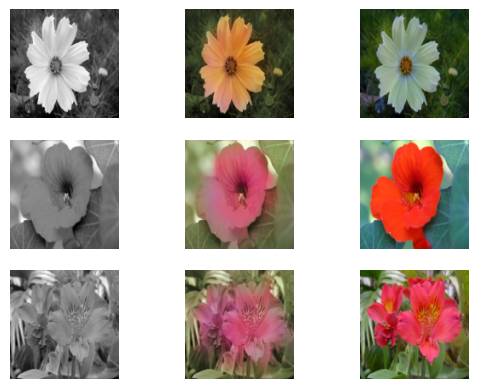

In [121]:
test_dataset = CustomFlowersDataset(root=root_dir, split="train", transform=transform, download=False)

data = select_n_random(test_dataset, n=3)

fig = plot_images_colorization(model, data)


In [114]:
torch.save(model.state_dict(), "./modelflower0%.pth")